# Short Time Series Biclustering

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import glob
import multiprocessing
from operator import attrgetter
from sklearn.datasets import make_biclusters
from sklearn.datasets import samples_generator as sg
from sklearn.preprocessing import MinMaxScaler

from metrics import *

In [2]:
data = pd.read_csv('TestData/SimulatedDataCoherence/BiclusterABC_high.csv',header=None)
scaler = MinMaxScaler()
scaler.fit(data)
data = scaler.transform(data)*2-1

data = np.concatenate((data,data),axis=0)

In [3]:
class BisectingClusterer(object):
    def __init__(self, data):
        if data is not None:
            self._data = np.array(data)
            self._I, self._J = self._data.shape
        else:
            print("Empty data")
    
    @property
    def centroids(self):
        return self._centroids

    def fit(self):
        self._centroids = self._compute_centroids_()
        bisecting_indices = self._bisect_clusters_(self._centroids)
        return bisecting_indices
    
    def fit_rows(self):
        return self.fit()
    
    def fit_cols(self):
        t_data = self._data.T
        aux_I, aux_J = t_data.shape
        assert aux_I >= 3, "bicluster not large enough"
        aux_indices = np.zeros(aux_I)
        #print(len(t_data))
        max_coherence = 0
        middle = 0
        for i in range (1, aux_I-1):
            # print("Bicluster A")
            # print(t_data[i:len(t_data)])
            h_A = PairBasedCoherence(t_data[i:len(t_data)]).HP
            #print(h_A)
            # print("Bicluster B")
            # print(t_data[0:i+1])
            h_B=PairBasedCoherence(t_data[0:i+1]).HP
            # print(h_B)
            temp_coherence = max(h_A,h_B)
            # print("sum " + str(temp_coherence))
            if(temp_coherence>=max_coherence):
                max_coherence = temp_coherence
                left_coherence = h_B
                right_coherence = h_A
                middle = i
           
        # print("middle " + str(middle))
        # print("left coherence " + str(left_coherence))
        # sns.tsplot(data = (t_data[0:middle]).T,err_style="unit_traces")
        # plt.show()
        # plt.gcf().clear()
        # print("right coherence " + str(right_coherence))
        # sns.tsplot(data = (t_data[middle:len(t_data)]).T,err_style="unit_traces")
        # print(max_coherence)
        indices = np.ones(aux_I)
        zeros = np.zeros(middle)
        indices[0:middle] = zeros
        return indices
        
    def _compute_centroids_(self):
        max_correlation = 0
        centroids = [0,0]
        for i in range(self._I):
            for j in range(i+1, self._I):
                if (i == j):
                    break
                correlation = PositiveNegativeCorrelation(self._data[i],
                                                          self._data[j],
                                                          self._J).H_neg
                if(correlation > max_correlation):
                    max_correlation = correlation
                    centroids[0] = i
                    centroids[1] = j
        return centroids

    def _bisect_clusters_(self, centroids):
        cluster_indices = np.zeros(self._I)
        for i in range(self._I):
            correlation0 = PositiveNegativeCorrelation(
                self._data[centroids[0]], self._data[i],self._J).H_pos
            correlation1 = PositiveNegativeCorrelation(
                self._data[centroids[1]], self._data[i],self._J).H_pos
            if(correlation0 <= correlation1):
                cluster_indices[i] = 1
        return cluster_indices

In [233]:
%%latex
Define H for a new term 'z' in X
$$
H_{1}(I,J,X,z) =H_{0}(I,J,X) \cdot \frac{(I-1)}{(I+1)} + \frac{|2|}{(I)(I+1)} \cdot \sum_{x \epsilon X} {h(x,z,J)}
$$

<IPython.core.display.Latex object>

In [235]:
test_arr = np.random.rand(3,3)
test_arr

array([[ 0.8511456 ,  0.60295857,  0.13425805],
       [ 0.47213802,  0.47630206,  0.63277489],
       [ 0.26446263,  0.10464854,  0.16078793]])

In [236]:
test_arr.T[3:4]

array([], shape=(0, 3), dtype=float64)

In [237]:
test_data = np.array(data)[np.ix_([0,8,27,39,42,43,49,54,72,74,79,86,88,108,113,122,142,158
,300,308,327,339,342,343,349,354,372,374,379,386,388,408,413,422,442,458],[0,1,2,3,4,5,6])]

In [238]:
cl_test = BisectingClusterer(aux_data)

11
Bicluster A
[[ 0.1995    -0.81686    0.91126    0.89402    0.46163   -0.08011    0.42141
   0.53015   -0.85382    0.88481   -0.69722    0.54625   -0.28963    0.68925
  -0.050249  -0.92655   -0.63542   -0.17184    0.40546   -0.10148   -0.17156
  -0.50587    0.13822    0.44981   -0.099292  -0.32389    0.80118    0.44174
   0.33534   -0.94095   -0.66222    0.49595    0.30335    0.97927    0.21629
   0.18584   -0.30748   -0.31537    0.71254    0.81949   -0.3676    -0.98096
  -0.25643   -0.94232    0.15596    0.947      0.18185   -0.43139   -0.80759
  -0.41435   -0.070261  -0.85427   -0.82945    0.2613     0.33683    0.80476
  -0.39398   -0.706      0.38151   -0.29827    0.61389    0.57832    0.60054
   0.75108   -0.58168    0.28016   -0.02799   -0.39831   -0.99718    0.46687
   0.7225    -0.40254    0.94453    0.56549   -0.12111    0.97654    0.49995
   0.79291    0.16555    0.70972    0.64533    0.7701    -0.61788    0.4254
   0.24378   -0.89142    0.92901    0.43473   -0.48748   -0.46

0.972647481592
Bicluster B
[[-0.39268   -0.64453   -0.32601   -0.44732    0.84951   -0.31545    0.18329
  -0.52972   -0.68178   -0.71917   -0.78407    0.98398    0.80136   -0.33991
   0.3076    -0.055434   0.15475   -0.98173   -0.65947   -0.097881   0.45801
  -0.89273   -0.80772   -0.0076987  0.50152   -0.39341    0.53377   -0.27083
   0.25694   -0.66957   -0.25368   -0.58079   -0.98965    0.27988    0.84083
  -0.87145   -0.58686    0.63734   -0.79369    0.053298  -0.55275    0.66601
  -0.98058   -0.81978   -0.79118   -0.6843     0.68954    0.40304   -0.82997
  -0.17393   -0.84097   -0.72005   -0.17648   -0.21588   -0.26727    0.44579
   0.24376    0.04225   -0.93752   -0.4215     0.47273    0.51099   -0.32536
   0.097338   0.52402   -0.90948    0.72136    0.66505    0.60093    0.95047
   0.77369    0.05875    0.34074    0.89117    0.039187  -0.79806   -0.96185
  -0.63656    0.26023    0.6966     0.18637    0.62958   -0.27434    0.6889
  -0.13302    0.50039    0.38627    0.54423    0.0

/home/a20125359/anaconda3/envs/Biclustering/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


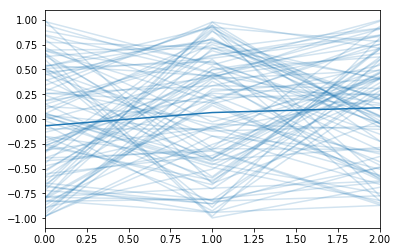

right coherence 0.979370721238
0.979370721238


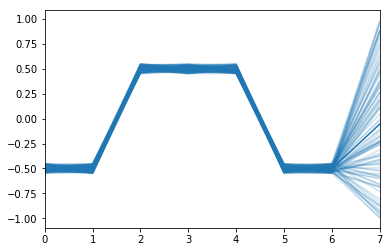

In [239]:
cl_test.fit_cols()

/home/a20125359/anaconda3/envs/Biclustering/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


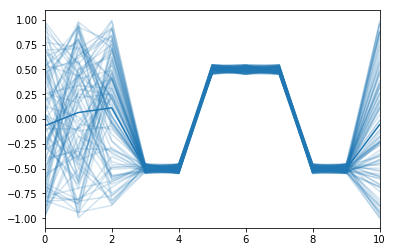

In [240]:
sns.tsplot(data= np.array(aux_data),err_style="unit_traces")

In [4]:
class ClusterMaps(object):
    def __init__(self, rho=None, gamma=None, H = 0):
        self.gamma = gamma
        self.rho = rho
        self.H = H
    
    def __str__(self):
        return ("rho: \n"+ str(self.rho) + "\ngamma: \n" + str(self.gamma) + "\nH: \n " + str(self.H))

In [5]:
class TsRapooc(object):
    def __init__(self, data, n_clusters = 5):
        self._D = np.array(data)
        self._n_clusters = n_clusters
        self._labels = list()
        self._I, self._J = data.shape
        self._cluster_count = 0
        
    @property
    def n_clusters(self):
        return self._n_clusters
    
    @property
    def data(self):
        return self._D
    
    @property
    def labels(self):
        return _labels
    
    def fit(self):
        n_iteration = 0
        n_clusters = 0
        for n_iteration in range(0, self._n_clusters-1):
            if n_iteration == 0:
                try:
                    initial_partition = BisectingClusterer(self._D).fit_rows()
                    self._labels.append(ClusterMaps(np.where(initial_partition==0)[0],
                                        np.arange(self._J),
                                        PairBasedCoherence(self._D[np.where(initial_partition==0)]).HP))

                    self._labels.append(ClusterMaps(np.where(initial_partition==1)[0],
                                       np.arange(self._J),
                                       PairBasedCoherence(self._D[np.where(initial_partition==1)]).HP))
                except IndexError:
                    print("Index error")
                    print("partition 0")
                    print(np.where(initial_partition==0))
                    print("partition 1")
                    print(np.where(initial_partition==1))
            else:
                self._partition()
            # print(n_iteration+1)
        
    def _partition(self):
        least_coherent, least_coherent_index = self._find_least_coherent()
        lowest_cluster = self._D[np.ix_(least_coherent.rho,least_coherent.gamma)]
        self._bisect_bicluster(lowest_cluster, least_coherent,least_coherent_index)
    
    def _find_least_coherent(self):
        
        return self._labels[self._labels.index(min(filter(lambda cluster: len(cluster.gamma)>2 and len(cluster.rho)>2 ,self._labels),key=attrgetter('H')))], self._labels.index(min(self._labels,key=attrgetter('H')))
    
    def _bisect_bicluster(self,cluster, cluster_node, node_index):
        #which of the biclusters maximize coherence
        rows_map = BisectingClusterer(cluster).fit_rows()
        cols_map = BisectingClusterer(cluster).fit_cols()
        
        flg_alls= 'none'
        
        if(np.all(cols_map) or np.all(rows_map)):
            # if all rows are in the same bicluster, then divide columns
            if(np.all(rows_map)):
                print(rows_map)
                flg_alls = 'cols'
            else:
                print(cols_map)
                flg_alls = 'rows'
        # print('\n'+flg_alls +" labels "+ str(node_index))
        if(flg_alls == 'none'):
            # find the coherences, the ones which raises the average coherences are the ones that are divided
            cols_coherence_1 = PairBasedCoherence(self._D[np.ix_(cluster_node.rho,cluster_node.gamma[np.flatnonzero(cols_map == 0)])]).HP
            cols_coherence_2 = PairBasedCoherence(self._D[np.ix_(cluster_node.rho,cluster_node.gamma[np.flatnonzero(cols_map == 1)])]).HP
            avg_cols = (cols_coherence_1 + cols_coherence_2)/2.0
            rows_coherence_1 = PairBasedCoherence(self._D[np.ix_(cluster_node.rho[np.flatnonzero(rows_map == 0)],cluster_node.gamma)]).HP
            rows_coherence_2 = PairBasedCoherence(self._D[np.ix_(cluster_node.rho[np.flatnonzero(rows_map == 1)],cluster_node.gamma)]).HP
            avg_rows = (rows_coherence_1 + rows_coherence_2)/2.0
            if (avg_cols>avg_rows):
                # print('cols division')
                col_cluster_1 = ClusterMaps(cluster_node.rho
                                        , cluster_node.gamma[np.flatnonzero(cols_map == 0)], cols_coherence_1)
                self._labels[node_index] = col_cluster_1
                col_cluster_2 = ClusterMaps(cluster_node.rho
                                        , cluster_node.gamma[np.flatnonzero(cols_map == 1)], cols_coherence_2)
                self._labels.append(col_cluster_2)
            else:
                # print('rows division')
                row_cluster_1 = ClusterMaps(cluster_node.rho[np.flatnonzero(rows_map == 0)], cluster_node.gamma, rows_coherence_1)
                self._labels[node_index] = row_cluster_1
                row_cluster_2 = ClusterMaps(cluster_node.rho[np.flatnonzero(rows_map == 1)], cluster_node.gamma, rows_coherence_2)
                self._labels.append(row_cluster_2)
        elif (flg_alls == 'cols'):
            cols_coherence_1 = PairBasedCoherence(self._D[np.ix_(cluster_node.rho,cluster_node.gamma[np.flatnonzero(cols_map == 0)])]).HP
            cols_coherence_2 = PairBasedCoherence(self._D[np.ix_(cluster_node.rho,cluster_node.gamma[np.flatnonzero(cols_map == 1)])]).HP
            col_cluster_1 = ClusterMaps(cluster_node.rho
                                        , cluster_node.gamma[np.flatnonzero(cols_map == 0)], cols_coherence_1)
            self._labels[node_index] = col_cluster_1
            col_cluster_2 = ClusterMaps(cluster_node.rho
                                        , cluster_node.gamma[np.flatnonzero(cols_map == 1)], cols_coherence_2)
            self._labels.append(col_cluster_2)
        else:
            rows_coherence_1 = PairBasedCoherence(self._D[np.ix_(cluster_node.rho[np.flatnonzero(rows_map == 0)],cluster_node.gamma)]).HP
            rows_coherence_2 = PairBasedCoherence(self._D[np.ix_(cluster_node.rho[np.flatnonzero(rows_map == 1)],cluster_node.gamma)]).HP
            row_cluster_1 = ClusterMaps(cluster_node.rho[np.flatnonzero(rows_map == 0)], cluster_node.gamma, rows_coherence_1)
            self._labels[node_index] = row_cluster_1
            row_cluster_2 = ClusterMaps(cluster_node.rho[np.flatnonzero(rows_map == 1)], cluster_node.gamma, rows_coherence_2)
            self._labels.append(row_cluster_2)
            
            

In [6]:
aux_data = pd.read_csv('TestData/SimulatedDataCoherence/BiclusterC_high.csv',header=None)

/home/a20125359/anaconda3/envs/Biclustering/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


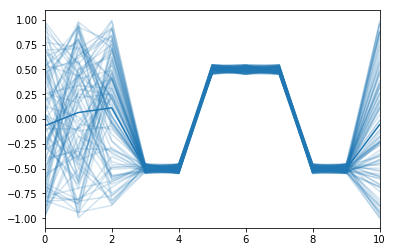

In [7]:
sns.tsplot(data= np.array(aux_data),err_style="unit_traces")

In [8]:
tsrapooc = TsRapooc(np.array(data),10)
tsrapooc.fit()

1.0 i 0

0.951721334613 i 1



/home/a20125359/anaconda3/envs/Biclustering/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


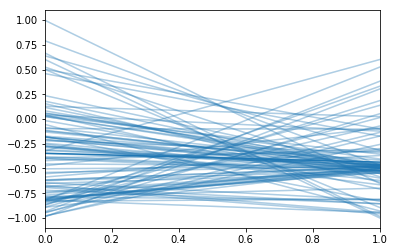

0.919083538469 i 2



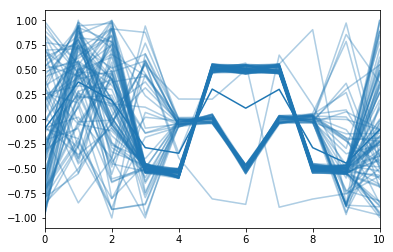

1.0 i 3

0.958644622346 i 4



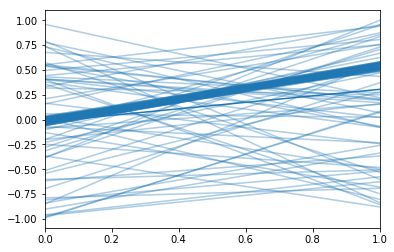

1.0 i 5

0.931219756813 i 6



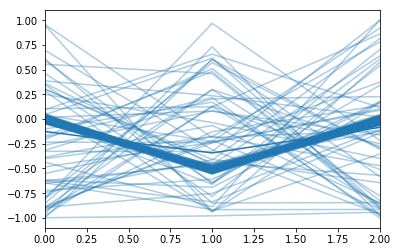

0.915740278438 i 7



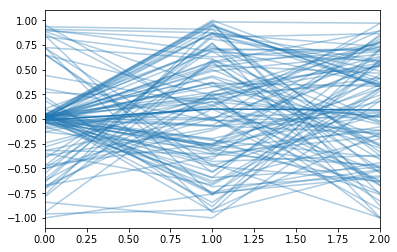

0.956454686429 i 8



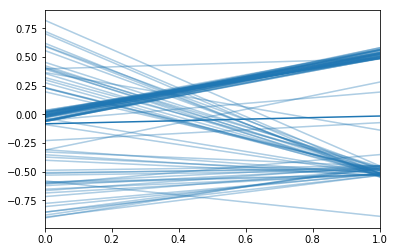

0.906890359103 i 9



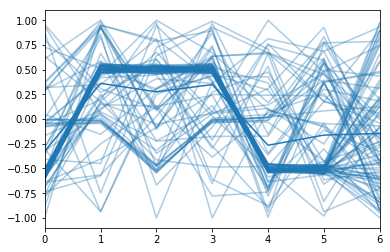

0


In [9]:
i = 0
max_coherence = 0
cluster = 0
for bicluster in tsrapooc._labels:
    print(str(bicluster.H) +" i "+ str(i)+"\n")
    if (len(bicluster.gamma)>1 and len(bicluster.rho)>1):
        sns.tsplot(data= tsrapooc._D[np.ix_(bicluster.rho,bicluster.gamma)],err_style="unit_traces")
        plt.show()
        plt.gcf().clear()
    if ((bicluster.H > max_coherence) and bicluster.H < 1.0):
        cluster = i
        max_coherence=bicluster.H
    i+=1
print(cluster)

/home/a20125359/anaconda3/envs/Biclustering/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


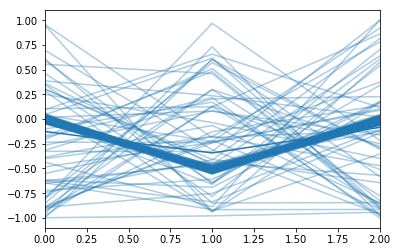

In [25]:
sns.tsplot(data= tsrapooc._D[np.ix_(tsrapooc._labels[6].rho,tsrapooc._labels[6].gamma)],err_style="unit_traces")

In [24]:
print(tsrapooc._labels[8])

rho: 
[  2   5   7  13  16  17  18  21  23  24  25  28  29  32  34  36  38  40
  44  45  47  48  50  53  57  59  60  61  62  63  65  68  69  73  76  81
  83  89  90  91  95  96 121 123 128 157 167 175 189 192 201 208 210 215
 216 217 219 220 221 222 224 225 229 230 232 235 236 237 240 241 242 243
 248 249 250 251 252 257 258 259 262 264 268 271 274 282 285 288 289 290
 291 292 293 294 297 302 305 307 313 316 317 318 321 323 324 325 328 329
 332 334 336 338 340 344 345 347 348 350 353 357 359 360 361 362 363 365
 368 369 373 376 381 383 389 390 391 395 396 421 423 428 457 467 475 489
 492 501 508 510 515 516 517 519 520 521 522 524 525 529 530 532 535 536
 537 540 541 542 543 548 549 550 551 552 557 558 559 562 564 568 571 574
 582 585 588 589 590 591 592 593 594 597]
gamma: 
[2 3]
H: 
 0.956454686429


/home/a20125359/anaconda3/envs/Biclustering/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


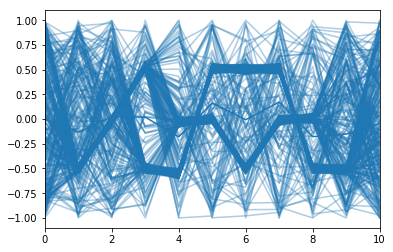

In [14]:
sns.tsplot(data, err_style= "unit_traces")